# Preliminary Operations
The same imports and auxiliary code is defined below:

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random as rn
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications.vgg16 import preprocess_input

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ROOT_DIR = "/content/drive/Shareddrives/Giaquinta_Pasqualetti/"
ROOT_DIR = "/content/sample_data/content/drive/Shareddrives/Giaquinta_Pasqualetti/"

IMAGES_DIR = os.path.join(ROOT_DIR, "Data")
TRAIN_DIR = os.path.join(IMAGES_DIR, "Train")
TEST_DIR = os.path.join(IMAGES_DIR, "Test")

IMAGE_DIM = 64
RAN_SEED = 10024062

VALIDATION_SPLIT = 0.1
TRAIN_SPLIT = 0.2

NOTE: Interactions with Google Drive are commented out. For our own testing, we used files stored locally in the session to **significantly** speed up the computation. To run this notebook using files stored in Google Drive, uncomment the lines that are currently commented and comment out the lines that are using local files.

In [ ]:
#! rm -r /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data
#! unzip -q /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data.zip -d /

! rm -r /content/sample_data/*
! unzip -q /content/Data.zip -d /content/sample_data/

In [ ]:
# Set all the seeds, to create datasets and Tensors from the same starting point
def set_seed():
    os.environ["PYTHONHASHSEED"]="0"
    np.random.seed(RAN_SEED)
    rn.seed(RAN_SEED)
    tf.random.set_seed(RAN_SEED)

# Returns Train, Val and Test sets
# BATCH_SIZE is user-given input, VALIDATION_SPLIT is 0.1
def load_datasets(BATCH_SIZE):
    set_seed()

    train = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='training', follow_links=False,
        image_size=(64,64)
    )

    val = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='validation', follow_links=False,
        image_size=(64,64)
    )

    test = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR, labels='inferred', label_mode='categorical',
        class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True,
        seed=RAN_SEED, follow_links=False, image_size=(64,64)
    )

    return train, val, test


# Test
def show_res(y_score, labels):

  y_pred = np.rint(y_score)

  y_true = np.asarray(labels)

  y_pred = np.argmax(y_score, axis=1)
  y_test = np.argmax(y_true, axis=1)

  print("Classification report: ")
  print(metrics.classification_report(y_test,y_pred ,digits = 4))


  cm = metrics.confusion_matrix(y_test, y_pred)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()


# Function to plot multi-class ROC curves
def plot_multiclass_roc(y_scores, test_labels):

    # Binarize labels
    y_true = label_binarize(np.argmax(test_labels, axis=1), classes=range(10))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves in a single plot
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


Importing the three chosen models for the ensemble

In [ ]:
our_model = tf.keras.models.load_model("/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/Model3.h5")
vgg_model = tf.keras.models.load_model("/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/vgg16_final.h5")
resnet_model = tf.keras.models.load_model("/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/resnet50_simple.h5")

## Loading the dataset and calculating the predictions of the 3 models
The first thing to do is to split the dataset and compute the predictions of the models

In [ ]:
# loading the dataset
train, val, test = load_datasets(BATCH_SIZE = 64)

data, labels = [], []

for data_batch, labels_batch in test:
  data.append(data_batch)
  labels.append(labels_batch)

data = tf.concat(data, axis=0)
labels = tf.concat(labels, axis=0)

# our model
our_test_scores = our_model.predict(data)
# vgg model
vgg_test_scores = vgg_model.predict(data)
# resnet model
resnet_test_scores = resnet_model.predict(data)

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
169/169 [==============================] - 3s 12ms/step


# Custom Ensemble function
To attempt a basic ensemble (due to having only 3 models), we chose to employ a majority vote methodology. If a consensus is reached among at least 2 models regarding a prediction, that particular prediction is selected. In cases where all 3 models exhibit divergent opinions, we decided to adopt the prediction offered by our model. It is the model with the highest accuracy and F1 scores, it should exhibit heightened accuracy across all other classes.

In [ ]:
# Create an empty array with the same shape as the original arrays
final_scores = np.zeros_like(our_test_scores)
# The array is initially created as the sum of the scores of the three models
final_scores = our_test_scores + vgg_test_scores + resnet_test_scores

# There are three cases:
# CASE 1: a cell contains a value equal to 3 and nine equal to 0; in this case we must transform 3->1
# CASE 2: a cell contains a value equal to 2, one equal to 1 and eight equal to 0; 2->1, 1->0, 0->0
# CASE 3: a cell contains three values equal to 1 and seven equal to 0; we adopt the prediction offered by our model
for i in range(final_scores.shape[0]):
    for j in range(final_scores.shape[1]):
        value = final_scores[i, j]

        if value == 3:
            final_scores[i, j] = 1
        elif value == 2:
            final_scores[i, j] = 1
            final_scores[i, (j+1)%10:] = 0
        elif np.sum(final_scores[i] == 1) == 3:
            final_scores[i] = our_test_scores[i]

# Print the resulting array
print(final_scores)

[[5.9821235e-04 2.5653976e-06 7.8666750e-07 ... 1.7761596e-07
  2.5209038e+00 5.1469215e-05]
 [1.0249624e-06 7.9866985e-10 7.2952583e-10 ... 1.1256210e-08
  2.6682375e-05 1.4968984e-11]
 [6.1183222e-05 1.3561903e-07 2.6954964e-08 ... 2.4951262e-08
  1.9074209e+00 5.3894792e-06]
 ...
 [1.2630916e-01 1.1568834e-07 2.9674909e-05 ... 1.0670031e-07
  3.2795831e-03 3.0703520e-06]
 [1.1823764e-03 6.4932480e-03 2.7939247e-03 ... 4.1728501e-05
  9.7999000e-05 2.9849353e+00]
 [4.3324791e-03 8.5070693e-05 8.7714143e-06 ... 2.9467168e-07
  5.9684170e-03 1.5284047e-04]]


# Results
 It appears that the ensemble model demonstrates a slight enhancement compared to the individual performance of the three models. This improvement is notably evident in the ROC curves. In terms of accuracy, the value is indeed higher than that achieved by the three individual models and the individuals F1 scores also improved.

Classification report: 
              precision    recall  f1-score   support

           0     0.9789    0.9283    0.9530       600
           1     0.9833    0.9800    0.9816       600
           2     0.9397    0.9350    0.9373       600
           3     0.9280    0.9020    0.9148       500
           4     0.9679    0.9660    0.9670       500
           5     0.8943    0.9725    0.9317       400
           6     0.8956    0.9260    0.9105       500
           7     0.9866    0.9833    0.9850       600
           8     0.9359    0.9340    0.9349       500
           9     0.9884    0.9917    0.9900       600

    accuracy                         0.9526      5400
   macro avg     0.9498    0.9519    0.9506      5400
weighted avg     0.9532    0.9526    0.9527      5400



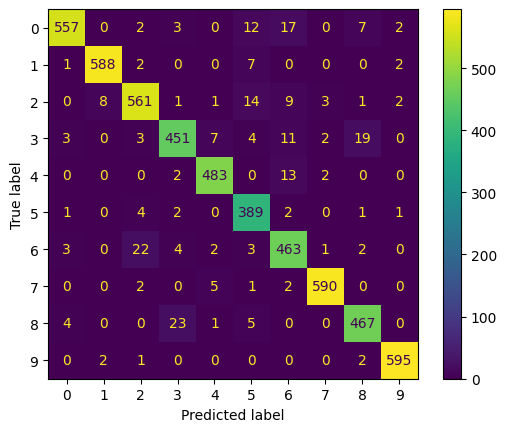

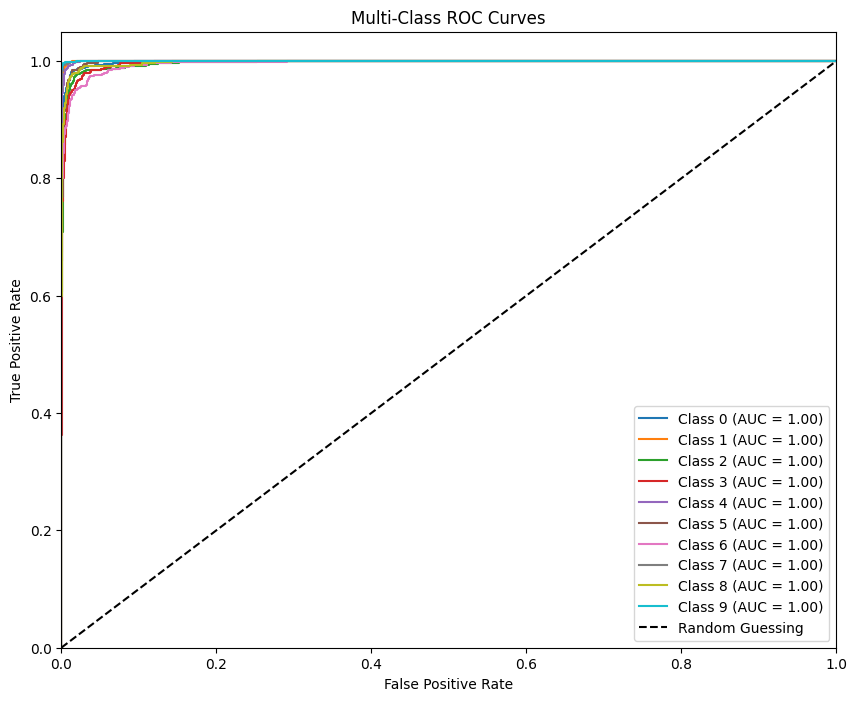

In [ ]:
show_res(final_scores, labels)
plot_multiclass_roc(final_scores, labels)